This notebook extracts well-tagged posts and splits them over chunks no more than 300 words, trying to preserve paragraph structure.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd
from pandas import DataFrame,Series
import seaborn as sns
from tqdm.auto import tqdm
import json
from datasets import Dataset, DatasetDict

from src.parsing import read_post_data, get_html_parser
from src.text_split import extract_paragraphs, split_long_paragraphs, collapse_paragraphs_iteratively
from src.paths import *

import wandb
from dotenv import load_dotenv
load_dotenv()

import nltk
nltk.download('punkt')

sns.set_theme(style="whitegrid")
tqdm.pandas()

In [3]:
wandb.login() # relies on WANDB_API_KEY env var
run = wandb.init(project="ea-forum-analysis", job_type="data_processing", dir=get_project_root())

wandb: Currently logged in as: vpetukhov. Use `wandb login --relogin` to force relogin


In [29]:
data = Dataset.load_from_disk(run.use_artifact("posts_raw:latest").download()).to_pandas()
data.shape

wandb: Downloading large artifact posts_raw:latest, 272.30MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.0


(11020, 16)

In [30]:
n_posts_per_tag = pd.value_counts(np.concatenate(data.tags.values))
sel_tags = set(n_posts_per_tag.index[n_posts_per_tag >= 30])
data['tags'] = data.tags.map(lambda ts: list(set(ts) & sel_tags))
data = data[(data.tags.map(len) >= 4) & (data.tags.map(len) < 10)]
data = data[data['body'].map(str.strip).map(len) > 50]
data.shape[0]

2172

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [33]:
max_n_words = 300
data['paragraphs'] = data.body.progress_map(extract_paragraphs)
data['paragraphs'] = data.paragraphs.progress_map(lambda p: split_long_paragraphs(p, max_n_words=max_n_words))
data['paragraphs_split'] = data.paragraphs.progress_map(lambda x: collapse_paragraphs_iteratively(x, max_n_words=max_n_words))

  0%|          | 0/2172 [00:00<?, ?it/s]

  0%|          | 0/2172 [00:00<?, ?it/s]

  0%|          | 0/2172 [00:00<?, ?it/s]

In [34]:
par_split_df = pd.concat([
    DataFrame({'postId': pid, 'tags': ";".join(r.tags), 'text': r.paragraphs_split.text.values}) 
    for pid,r in data.iterrows()
], ignore_index=True)
par_split_df.shape

(31798, 3)

In [35]:
np.random.seed(42)
all_posts = par_split_df.postId.unique()
dev_posts = np.random.choice(all_posts, size=int(all_posts.size * 0.1), replace=False)

train_pars = par_split_df[~par_split_df.postId.isin(dev_posts)]
dev_pars = par_split_df[par_split_df.postId.isin(dev_posts)]

In [36]:
def jaccard_similarity(a:set, b:set):
    return len(a & b) / len(a | b)


def extract_paired_posts(post_id:str, selected_sims:np.ndarray, tags_per_post:Series, n_texts_per_post:int=1):
    t1 = tags_per_post[post_id]
    sims = tags_per_post.map(lambda t2: jaccard_similarity(t1, t2))
    freqs = [(1 - np.abs(sims - s)) ** 30 for s in selected_sims] # 30 is a severe penalty for distance. Adjusts for class imbalance.
    sel_posts = np.concatenate([
        np.random.choice(fs.index.values, p=(fs.values / fs.sum()), size=n_texts_per_post, replace=True) 
        for fs in freqs
    ])

    return sel_posts, sims[sel_posts].values


def extract_text_distance_pairs(df:DataFrame, tags_per_post:Series, n_pairs_per_text:int, n_texts_per_post:int=1):
    selected_sims = np.linspace(0, 1, n_pairs_per_text)

    texts_per_post = df.text.groupby(df.postId).apply(np.array)
    tags_per_post = tags_per_post[texts_per_post.index]
    texts_per_post = dict(texts_per_post)

    pair_dfs = []
    for pid,texts in tqdm(texts_per_post.items(), total=len(texts_per_post)):
        src_texts = np.random.choice(texts, size=(n_texts_per_post * n_pairs_per_text), replace=True)
        dst_pids, dst_sims = extract_paired_posts(
            pid, selected_sims=selected_sims, tags_per_post=tags_per_post, 
            n_texts_per_post=n_texts_per_post
        )
        dst_texts = np.concatenate([np.random.choice(texts_per_post[pid], size=1, replace=True) for pid in dst_pids])
        pair_dfs.append(DataFrame({'src_text': src_texts, 'dst_text': dst_texts, 'src_post_id': pid, 'dst_post_id': dst_pids, 'sims': dst_sims}))
    
    pair_df = pd.concat(pair_dfs, ignore_index=True)
    pair_df = pair_df[~pair_df[['src_text', 'dst_text']].duplicated()]
    reverse_pairs = set(pair_df.dst_text + ' ' + pair_df.src_text)
    reverse_mask = np.array([(t in reverse_pairs) for t in (pair_df.src_text + ' ' + pair_df.dst_text)])
    pair_df = pair_df[~reverse_mask]

    return pair_df.reset_index(drop=True)

In [37]:
tags_per_post = data.tags[all_posts].map(set)

In [66]:
train_pair_df = extract_text_distance_pairs(train_pars, tags_per_post, n_pairs_per_text=12, n_texts_per_post=10)
train_pair_df.shape

  0%|          | 0/1955 [00:00<?, ?it/s]

(174991, 5)

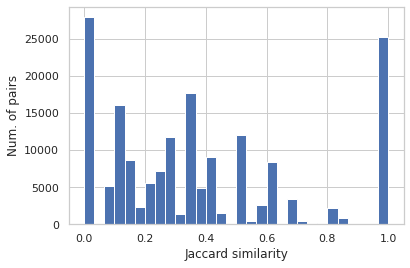

In [67]:
train_pair_df.sims.hist(bins=30);
plt.xlabel('Jaccard similarity'); plt.ylabel('Num. of pairs');

In [68]:
dev_pair_df = extract_text_distance_pairs(dev_pars, tags_per_post, n_pairs_per_text=12, n_texts_per_post=2)
dev_pair_df.shape

  0%|          | 0/217 [00:00<?, ?it/s]

(4220, 5)

In [71]:
dataset = DatasetDict({"train": Dataset.from_pandas(train_pair_df), "dev": Dataset.from_pandas(dev_pair_df)})
dataset.save_to_disk(datap('post_pairs'))
dataset

DatasetDict({
    train: Dataset({
        features: ['src_text', 'dst_text', 'src_post_id', 'dst_post_id', 'sims'],
        num_rows: 174991
    })
    dev: Dataset({
        features: ['src_text', 'dst_text', 'src_post_id', 'dst_post_id', 'sims'],
        num_rows: 4220
    })
})

In [72]:
art = wandb.Artifact("post_pairs", type="dataset")
art.add_dir(datap('post_pairs'))
run.log_artifact(art)

wandb: Adding directory to artifact (/notebooks/data/post_pairs)... Done. 2.9s


In [73]:
wandb.finish()